In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Загрузка данных с правильной кодировкой
df = pd.read_csv('data.csv', encoding='latin1')  # или 'cp1251', если не сработает

# Просмотр первых строк и общей информации о данных
print("Первые 5 строк данных:")
display(df.head())

print("\nИнформация о датасете:")
df.info()

print("\nОсновные статистики:")
display(df.describe())

Первые 5 строк данных:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Основные статистики:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [157]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [158]:
# Преобразование даты в формат datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Фильтрация данных:
# - Удаляем записи без CustomerID
# - Удаляем записи с отрицательным количеством или ценой
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Расчет общей стоимости для каждой строки
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Установка последней даты в данных как точки отсчета для расчета Recency
snapshot_date = df['InvoiceDate'].max()

print(f"Период данных: с {df['InvoiceDate'].min()} по {df['InvoiceDate'].max()}")
print(f"Количество записей после фильтрации: {df.shape[0]}")

Период данных: с 2010-12-01 08:26:00 по 2011-12-09 12:50:00
Количество записей после фильтрации: 397884


## расчёт RFM

Статистика по RFM-метрикам:


,R,F,M
count,4338.000000,4338.000000,4338.000000
mean,91.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,307.415000
50%,50.000000,2.000000,674.485000
75%,141.000000,5.000000,1661.740000
max,373.000000,209.000000,280206.020000


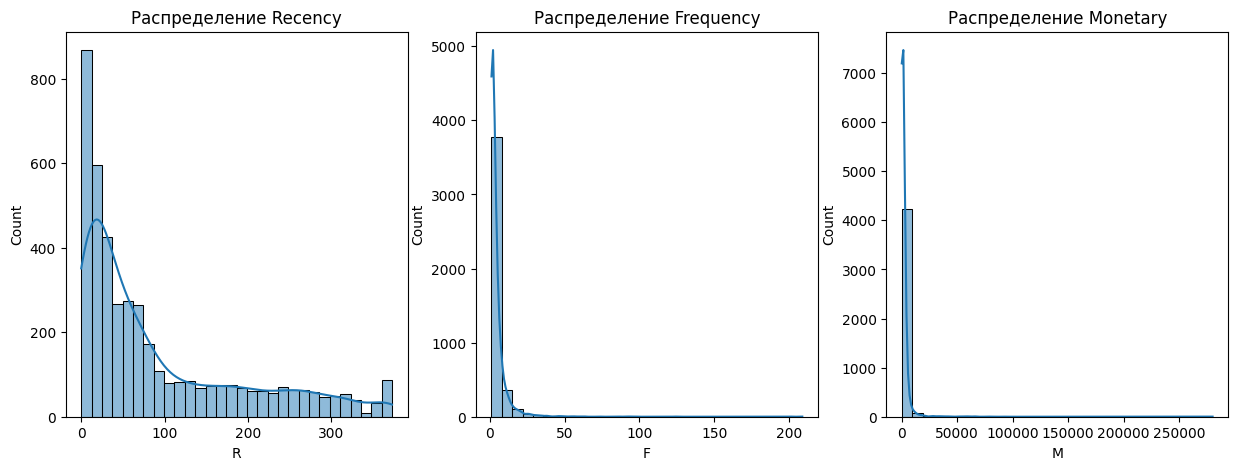

In [159]:
# Расчет RFM-метрик для каждого клиента
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).rename(columns={
    'InvoiceDate': 'R',
    'InvoiceNo': 'F',
    'TotalPrice': 'M'
})

# Просмотр распределения метрик
print("Статистика по RFM-метрикам:")
display(rfm.describe())

# Визуализация распределения метрик
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['R'], bins=30, kde=True)
plt.title('Распределение Recency')

plt.subplot(1, 3, 2)
sns.histplot(rfm['F'], bins=30, kde=True)
plt.title('Распределение Frequency')

plt.subplot(1, 3, 3)
sns.histplot(rfm['M'], bins=30, kde=True)
plt.title('Распределение Monetary')

plt.show()

## Присвоение RFM-оценок

In [160]:
# Определяем квантили для разделения на группы (используем 33% и 66% перцентили)
r_quantiles = rfm['R'].quantile([0.33, 0.66]).values
f_quantiles = rfm['F'].quantile([0.33, 0.66]).values
m_quantiles = rfm['M'].quantile([0.33, 0.66]).values

# Функция для присвоения оценок (универсальная)
def assign_score(value, quantiles, reverse=False):
    """
    reverse=True: для Recency (меньшее значение = лучше)
    reverse=False: для Frequency и Monetary (большее значение = лучше)
    """
    if reverse:  # Для Recency (R): чем меньше значение, тем лучше
        if value <= quantiles[0]:
            return 1  # Лучшие клиенты (недавно покупали)
        elif value <= quantiles[1]:
            return 2  # Средние клиенты
        else:
            return 3  # Худшие клиенты (давно не покупали)
    else:  # Для Frequency (F) и Monetary (M): чем больше значение, тем лучше
        if value > quantiles[1]:
            return 1  # Лучшие клиенты (часто покупают/много тратят)
        elif value > quantiles[0]:
            return 2  # Средние клиенты
        else:
            return 3  # Худшие клиенты (редко покупают/мало тратят)

# Присваиваем оценки
# Для Recency используем reverse=True (меньшее значение = лучше)
rfm['R_Score'] = rfm['R'].apply(lambda x: assign_score(x, r_quantiles, reverse=True))
# Для Frequency и Monetary используем reverse=False (большее значение = лучше)
rfm['F_Score'] = rfm['F'].apply(lambda x: assign_score(x, f_quantiles, reverse=False))
rfm['M_Score'] = rfm['M'].apply(lambda x: assign_score(x, m_quantiles, reverse=False))
print("Распределение оценок после присвоения:")
print(f"R_Score: {rfm['R_Score'].value_counts().sort_index().to_dict()}")
print(f"F_Score: {rfm['F_Score'].value_counts().sort_index().to_dict()}")
print(f"M_Score: {rfm['M_Score'].value_counts().sort_index().to_dict()}")
# Создаем общий RFM-код
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

def assign_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r == 1 and f == 1 and m == 1:
        return 'Топчик'
    
    if r == 1 and f == 1 and m != 1:
        return 'Активные, экономные'
    
    if r == 3 and f == 3:
        return 'Редкие'
    
    if r == 3 and f == 1 and m == 1:
        return 'Топчик, но ушли'

    if r == 2 and f == 2 and m == 2:
        return 'Баланс'
        
    if r == 3:
        return 'Недавние'
    
    return 'Остальные'

# Применяем функцию
rfm['Segment'] = rfm.apply(assign_segment, axis=1)

print("RFM-метрики с оценками для первых 10 клиентов:")
display(rfm.head(10))

Распределение оценок после присвоения:
R_Score: {1: 1464, 2: 1406, 3: 1468}
F_Score: {1: 1114, 2: 1731, 3: 1493}
M_Score: {1: 1475, 2: 1431, 3: 1432}
RFM-метрики с оценками для первых 10 клиентов:


,R,F,M,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,3,3,1,331,Редкие
12347.0,1,7,4310.00,1,1,1,111,Топчик
12348.0,74,4,1797.24,2,2,1,221,Остальные
12349.0,18,1,1757.55,1,3,1,131,Остальные
12350.0,309,1,334.40,3,3,3,333,Редкие
12352.0,35,8,2506.04,2,1,1,211,Остальные
12353.0,203,1,89.00,3,3,3,333,Редкие
12354.0,231,1,1079.40,3,3,2,332,Редкие
12355.0,213,1,459.40,3,3,2,332,Редкие


In [161]:
display((rfm['F_Score']==1).sum(),
(rfm['F_Score']==2).sum(),
(rfm['F_Score']==3).sum(),
(rfm['M_Score']==1).sum(),
(rfm['M_Score']==2).sum(),
(rfm['M_Score']==3).sum())

np.int64(1114)

np.int64(1731)

np.int64(1493)

np.int64(1475)

np.int64(1431)

np.int64(1432)

Количество клиентов в каждом сегменте:
Segment
Остальные              1804
Редкие                  856
Топчик                  658
Недавние                563
Баланс                  341
Активные, экономные      67
Топчик, но ушли          49
Name: count, dtype: int64

Средние значения метрик по сегментам:


,R,F,M
Segment,,,
"Активные, экономные",10.42,5.75,896.54
Баланс,51.34,2.70,727.65
Недавние,174.64,2.68,981.46
Остальные,35.22,3.03,1337.71
Редкие,238.97,1.00,422.48
Топчик,8.52,13.71,7791.40
"Топчик, но ушли",140.14,7.67,3041.44


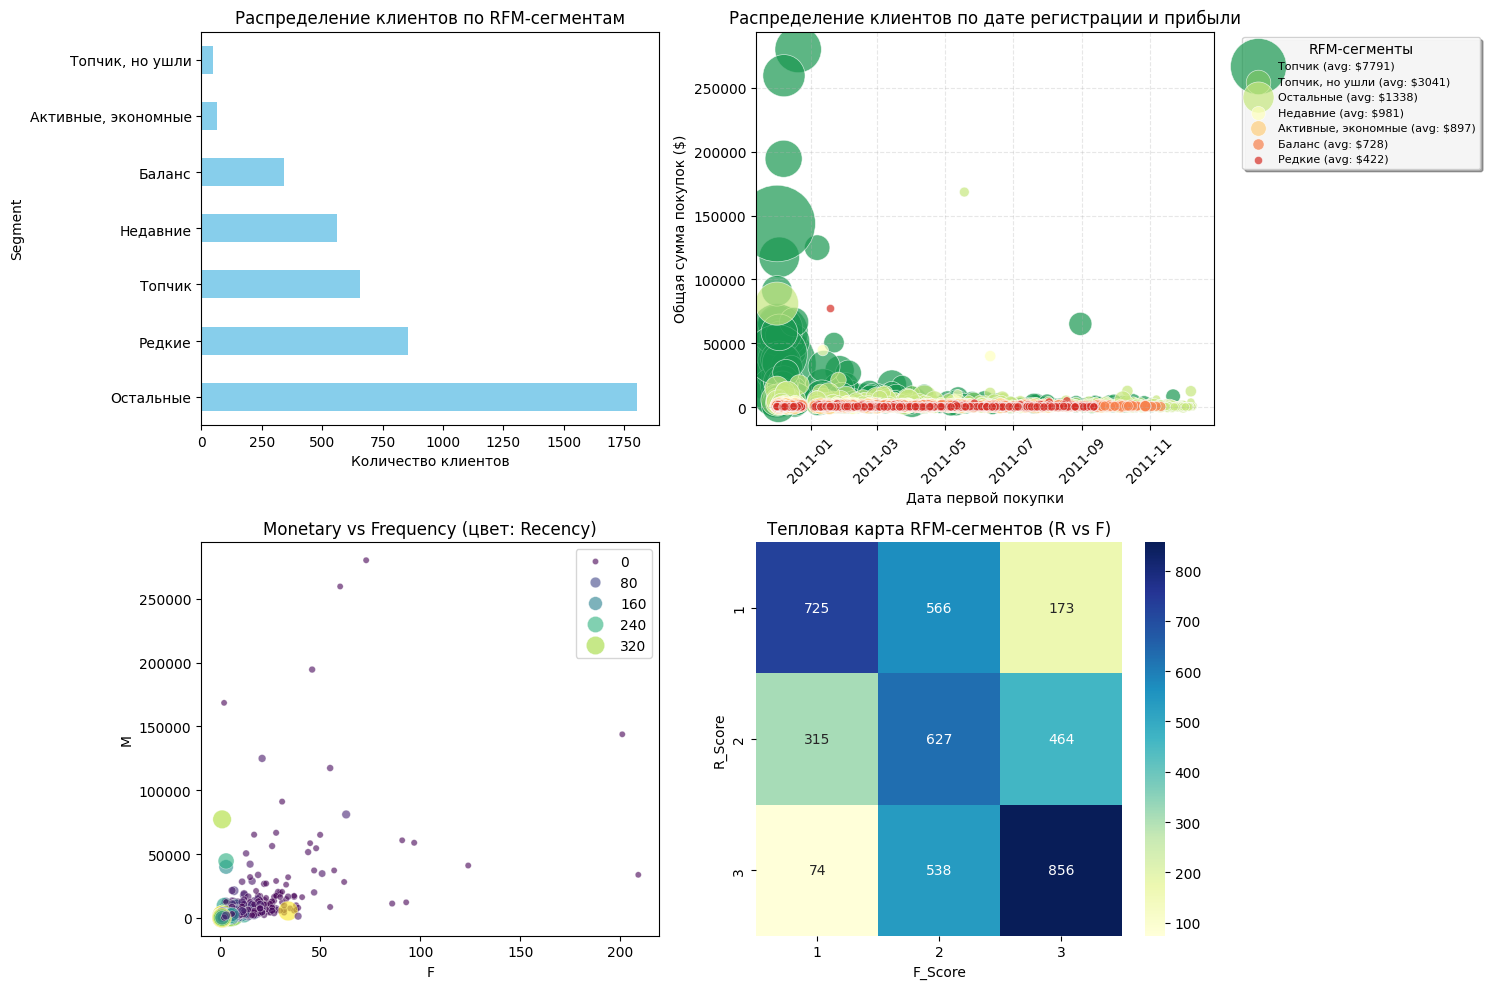

In [162]:
# Анализ распределения по сегментам
segment_counts = rfm['Segment'].value_counts()
segment_means = rfm.groupby('Segment').agg({
    'R': 'mean',
    'F': 'mean',
    'M': 'mean'
}).round(2)

print("Количество клиентов в каждом сегменте:")
print(rfm['Segment'].value_counts())

print("\nСредние значения метрик по сегментам:")
display(segment_means)

# Визуализация распределения по сегментам
plt.figure(figsize=(15, 10))

# График 1: Распределение клиентов по сегментам
plt.subplot(2, 2, 1)
segment_counts.plot(kind='barh', color='skyblue')
plt.title('Распределение клиентов по RFM-сегментам')
plt.xlabel('Количество клиентов')

# Вместо текущего "Графика 2" используем:
# График 2: Распределение клиентов по дате регистрации и прибыли
plt.subplot(2, 2, 2)

# Вычисляем дату первой покупки для каждого клиента (дата регистрации)
customer_first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
customer_first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']

# Объединяем с RFM данными
rfm_reset = rfm.reset_index()
rfm_with_dates = pd.merge(rfm_reset, customer_first_purchase, on='CustomerID', how='left')

# Определяем порядок сегментов по средней прибыли (от самых прибыльных к наименее)
segment_profitability = rfm_with_dates.groupby('Segment')['M'].mean().sort_values(ascending=False)
segment_order = segment_profitability.index.tolist()

# Создаем цветовую палитру от зеленого к красному
num_segments = len(segment_order)
colors = plt.cm.RdYlGn(np.linspace(0.1, 0.9, num_segments))[::-1]  # Инвертируем для зеленого->красного

# Строим график для каждого сегмента отдельно для корректной легенды
for i, segment in enumerate(segment_order):
    segment_data = rfm_with_dates[rfm_with_dates['Segment'] == segment]
    
    # Размер точек зависит от частоты покупок (Frequency)
    sizes = segment_data['F'] * 15 + 20  # Базовый размер + масштабирование
    
    plt.scatter(
        segment_data['FirstPurchaseDate'],
        segment_data['M'],
        color=colors[i],
        s=sizes,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5,
        label=f"{segment} (avg: ${segment_profitability[segment]:.0f})"
    )

plt.title('Распределение клиентов по дате регистрации и прибыли')
plt.xlabel('Дата первой покупки')
plt.ylabel('Общая сумма покупок ($)')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# Добавляем легенду справа от графика
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    title='RFM-сегменты', 
    fontsize=8,
    frameon=True,
    framealpha=0.9,
    shadow=True
)

# Автоматически настраиваем отступы для легенды
plt.tight_layout()

# График 3: Диаграмма рассеяния Monetary vs Frequency с цветовой кодировкой Recency
plt.subplot(2, 2, 3)
sns.scatterplot(data=rfm, x='F', y='M', 
                hue='R', size='R', 
                sizes=(20, 200), palette='viridis', alpha=0.6)
plt.title('Monetary vs Frequency (цвет: Recency)')
plt.legend(loc='best')

# График 4: Тепловая карта RFM-сегментов
rfm_counts = rfm.groupby(['R_Score', 'F_Score']).size().unstack()
plt.subplot(2, 2, 4)
sns.heatmap(rfm_counts, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Тепловая карта RFM-сегментов (R vs F)')
plt.xlabel('F_Score')
plt.ylabel('R_Score')

plt.tight_layout()
plt.savefig('rfm_analysis.png')
plt.show()
